# __DFT Code for harmonic Osciilator__

### Importing the Required Libraries

In [10]:
import numpy as np
import scipy as sp
import math as m

## <u>1-D Harmonic Oscillator</u>

The Hamiltonian for the harmonic oscillator is given by the following equation:
$$H = -\frac{1}{2} \frac{d^2}{dx^2} + \frac{1}{2}x^2$$

### Creating the Grid and the derivative matrix

In [11]:
n=200
L=5
x=np.linspace(-L,L,n)
h=x[1]-x[0]

Here:
- D is the derivative operator. np.eye(n) creates an n x n identity matrix, where n is the size of the matrix and np.diagflat(np.ones(n-1),1) create a matrix with the first upper diagonal filled with ones. so D is matrix that had -1 on main diagonal and 1 on the diagonal just above the main diagonal. This is derived by the fact that the $\frac{dy}{dx} = \frac{y_{i+1} - y_{i}}{h}$

- D2 is the second derivative operator. It is derived by the fact that $\frac{d^2y}{dx^2} = \frac{y_{i+1} - 2y_{i} + y_{i-1}}{h^2}$. D.T represents the transpose of matrix D and -D.T negates each element of the transpose of D. and their product is the dot product of the two matricesw hich results in the second derivative matrix.
- D2[-1,-1]=D2[0,0]: This is done because at the end of the grids, the second derivatives and derivatives are not defined very well.

In [12]:
D=-np.eye(n)+np.diagflat(np.ones(n-1),1)
D = D / h
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

### Creating the Potential Matrix

The potential matrix will contain the value of the potential at each point in the grid. The potential for the harmonic oscillator is given by the equation:
$$V(x) = \frac{1}{2}x^2$$

So the matrix elements are given by:
$$V_{ij} = \frac{1}{2}x_i^2\delta_{ij}$$

In [13]:
X=np.diagflat(x*x/2)               # potential energy: This returns the diagonal matrix with x^2/2 on the diagonal
E, psi_harmonic = np.linalg.eigh(-D2/2+X)   # This returns the eigenvalues and eigenvectors of the Hamiltonian

### Plotting the results

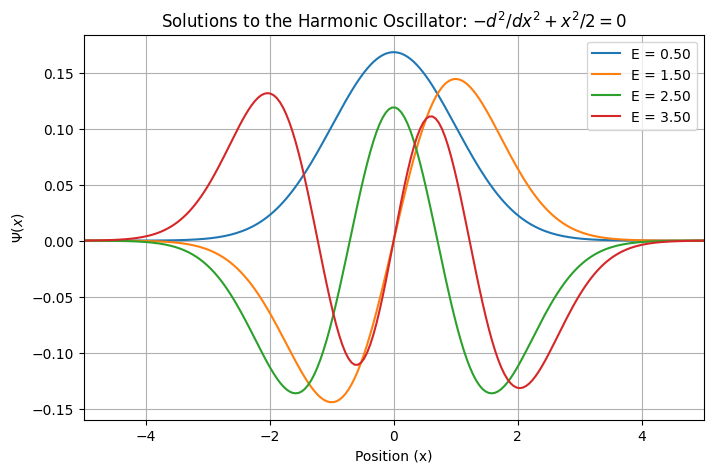

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for i in range(4):
    plt.plot(x, psi_harmonic[:, i], label=f"E = {E[i]:.2f}")
plt.xlabel("Position (x)")
plt.ylabel(r"$\Psi(x)$")
plt.legend(loc=1)
plt.title("Solutions to the Harmonic Oscillator: $-d^2/dx^2 +  x^2 /2 = 0$")
plt.xlim(-L, L)
plt.grid()
plt.show()

<h3> Including the Hartree and LDA potentials </h3>

let $f_n$ be occupation numbers, the density $n(x)$ can be written as follows:\n

$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

so we have to define the integral

In [15]:
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

### Defining n(x)

In [16]:
num_electron=2
def get_nx(num_electron, psi, x):
    I=integral(x,psi**2,axis=0)
    psi_normalized=psi/np.sqrt(I)[None, :]

    f_n=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        f_n.append(1)

    res=np.zeros_like(psi_normalized[:,0])
    for n_e, psi  in zip(f_n,psi_normalized.T):
        res += n_e*(psi**2)
    return res

### Plotting n(x)

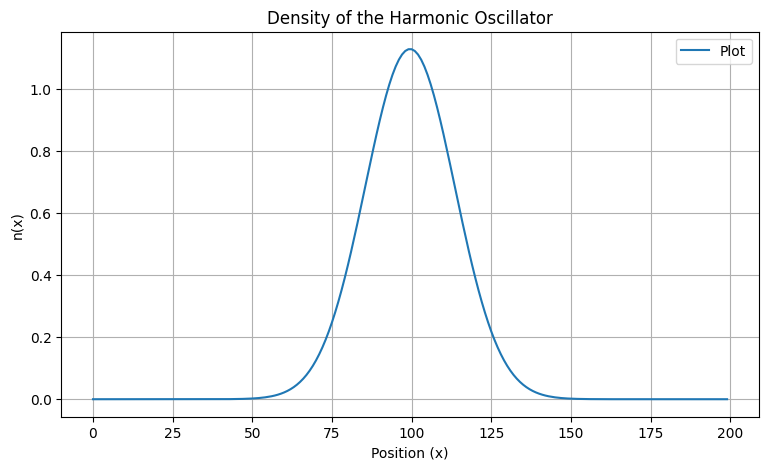

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.plot(get_nx(num_electron,psi_harmonic, x), label="Plot")
plt.legend(loc=1)
plt.title("Density of the Harmonic Oscillator")
plt.grid()
plt.xlabel("Position (x)")
plt.ylabel(r"n(x)")
plt.show()

### Defining the Exchange Energy

In [18]:
def get_exchange_energy(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

### Defining the Hartree Energy

In [19]:
def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

In [20]:
nx = np.zeros(n)

tolerence = 1e-5

# Running the loop once to get the initial values of the energies
hartree_energies_0 = get_hatree(nx,x)
exchange_energies_0 = get_exchange_energy(nx,x)
H=-D2/2+np.diagflat(exchange_energies_0[1]+hartree_energies_0[1]+x*x)
energy_0, psi_0= np.linalg.eigh(H)
nx_0=get_nx(num_electron,psi_0,x)
steps = 1

while True:
    hartree_energies_1 = get_hatree(nx_0,x)
    exchange_energies_1 = get_exchange_energy(nx_0,x)
    H=-D2/2+np.diagflat(exchange_energies_1[1]+hartree_energies_1[1]+x*x)
    energy_1, psi_1= np.linalg.eigh(H)
    nx_1=get_nx(num_electron,psi_1,x)
    if abs(energy_1[0] - energy_0[0]) < tolerence:
        print(f"converged after {steps} steps" )
        break
    elif steps > 1000:
        print(f"Did not converge after {steps} steps. Exiting.")
        break
    else:
        energy_0 = energy_1
        psi_0 = psi_1
        nx_0 = nx_1
        steps += 1


converged after 12 steps


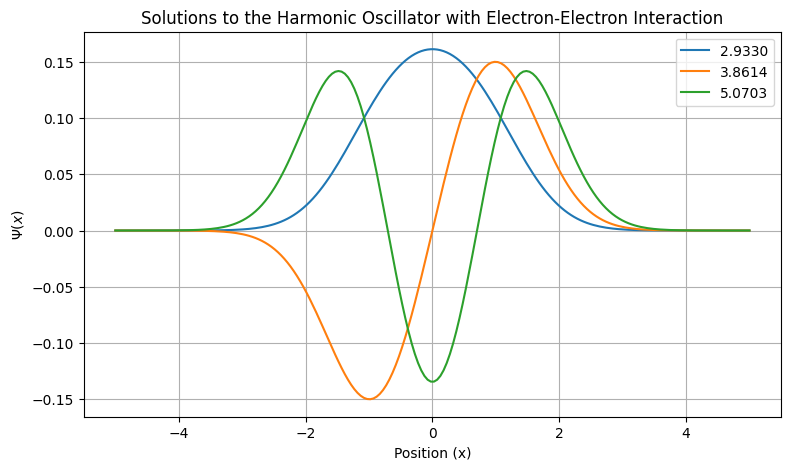

In [23]:
plt.figure(figsize=(9,5))
for i in range(3):
    plt.plot(x,psi_0[:,i], label=f"{energy_0[i]:.4f}")
    plt.legend(loc=1)
plt.grid()
plt.title("Solutions to the Harmonic Oscillator with Electron-Electron Interaction")
plt.xlabel("Position (x)")
plt.ylabel(r"$\Psi(x)$")
plt.show()    